<a href="https://colab.research.google.com/github/psrikararavind/Face-and-Expression-Recognition/blob/main/Face%2CExpression_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q kaggle
from google.colab import files
uploaded = files.upload()

import os

# Create kaggle directory and move kaggle.json there
os.makedirs('/root/.kaggle', exist_ok=True)
!mv kaggle.json /root/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

# Download dataset


! kaggle datasets download vasukipatel/face-recognition-dataset

import zipfile
# Unzip the dataset


with zipfile.ZipFile("face-recognition-dataset.zip", 'r') as zip_ref:
    zip_ref.extractall("/content/dataset")

TypeError: 'NoneType' object is not subscriptable

In [ ]:
import os
import torch   #we used pytorch
import torch.nn as nn  #setting up neural network
import torch.optim as optim  # we used optimizer adam
import torchvision.transforms as transforms  #we used for image processing
from torchvision.datasets import ImageFolder  # preprocessing kind of ,loads images
from torch.utils.data import random_split, DataLoader  # splitting data test , vlidation etc
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score  #accuracy
import numpy as np  #visualizations
import torch.nn.functional as F



# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# Hyperparameters
BATCH_SIZE = 32
LR = 0.001   #we used 10^-3
EPOCHS = 10
IMG_SIZE = 128
SEED = 42

# Reproducibility
torch.manual_seed(SEED)

In [ ]:
import os
import pandas as pd
from PIL import Image   #we used for loads and processes images.
from torch.utils.data import Dataset
from torchvision import transforms  #will allow applying things like resize, crop, normalize, etc.

class CSVImageDataset(Dataset):
    def __init__(self, csv_file, img_dir, label_column='label', transform=None):
        """
csv_file (str): Path to CSV file.
img_dir (str): Directory with all images.
label_column (str): Column in CSV to use as label (e.g., 'label' for face recognition or 'facial_expression').
transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.annotations = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform
        self.label_column = label_column

        # Create label <-> index mapping for the selected label column
        self.classes = sorted(self.annotations[label_column].unique())
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        img_name = self.annotations.iloc[idx]['id']
        label_name = self.annotations.iloc[idx][self.label_column]

        img_path = os.path.join(self.img_dir, img_name)
        image = Image.open(img_path).convert("RGB")
        label = self.class_to_idx[label_name]

        if self.transform:
            image = self.transform(image)

        return image, label


In [ ]:
# import os
# import pandas as pd
# from PIL import Image
# from torch.utils.data import Dataset
# from torchvision import transforms

# class CSVImageDataset(Dataset):
#     def __init__(self, csv_file, img_dir, label, transform=None):
#         self.annotations = pd.read_csv(csv_file)
#         self.img_dir = img_dir
#         self.transform = transform

#         # Create label <-> index mapping (e.g., cat → 0, dog → 1)
#         self.classes = sorted(self.annotations[label].unique())
#         self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}

#     def __len__(self):
#         return len(self.annotations)

#     def __getitem__(self, idx):
#         img_name = self.annotations.iloc[idx, 0]  # filename
#         label_name = self.annotations.iloc[idx, 1]  # class label (e.g., 'cat')

#         img_path = os.path.join(self.img_dir, img_name)
#         image = Image.open(img_path).convert("RGB")
#         label = self.class_to_idx[label_name]

#         if self.transform:
#             image = self.transform(image)

#         return image, label


In [ ]:
# Image transforms
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

val_test_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])


# Load dataset
# dataset = ImageFolder(root='/content/dataset/PetImages', transform=transform)
dataset = CSVImageDataset(csv_file='/content/dataset/updated_dataset.csv', img_dir='/content/dataset/Faces/Faces',label_column='facial_expression', transform=None)

class_names = dataset.classes
num_classes = len(class_names)
print("Classes:", class_names, len(class_names))

# Split dataset
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset)) # Evaluation during training time
test_size = len(dataset) - train_size - val_size # Evaluation after training
train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])

train_ds.dataset.transform = train_transform
val_ds.dataset.transform = val_test_transform
test_ds.dataset.transform = val_test_transform

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)  # Loads data in mini-batches (controlled by BATCH_SIZE),Shuffles training data for better learning,Keeps val/test data in order (no shuffle) for consistent evaluation

val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)



Classes: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise'] 7


In [ ]:
# Training function
def train_model(model, train_loader, val_loader, epochs):
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
# training loop
    for epoch in range(epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0   #initializes counters of rcurrent epoch
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()    #forward pass Get model predictions
            outputs = model(inputs)    #Backward pass: Calculate gradients
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0) #Keeps track of total loss (multiplied by batch size)
            preds = torch.argmax(outputs, dim=1)
            correct += (preds == labels).sum().item()   #Calculates accuracy by comparing predictions with actual labels
            total += labels.size(0)

        epoch_loss = running_loss / total
        epoch_acc = correct / total
        train_losses.append(epoch_loss)
        train_accs.append(epoch_acc)

        # Validation
        model.eval()
        val_loss, correct, total = 0.0, 0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
                preds = torch.argmax(outputs, dim=1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)

        val_losses.append(val_loss / total)
        val_accs.append(correct / total)

        print(f"Epoch [{epoch+1}/{epochs}], "
              f"Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}, "
              f"Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accs[-1]:.4f}")

    return train_losses, val_losses, train_accs, val_accs

In [ ]:
def evaluate(model, dataloader):
    model.eval()
    y_true, y_pred = [], []

    with torch.no_grad():
        for x, y in dataloader:
            x = x.to(device)
            outputs = model(x)
            preds = torch.argmax(outputs, dim=1).cpu().numpy()   #argmax finds the predicted class with the highest score#Moves predictions to CPU and converts to NumPy arrays

            y_true.extend(y.numpy())
            y_pred.extend(preds)

    acc = accuracy_score(y_true, y_pred)
    print("Test Accuracy:", acc)

## Training model from scratch

Epoch [1/10], Train Loss: 1.1998, Train Acc: 0.5471, Val Loss: 1.0891, Val Acc: 0.5391
Epoch [2/10], Train Loss: 1.0802, Train Acc: 0.5817, Val Loss: 1.1272, Val Acc: 0.5208
Epoch [3/10], Train Loss: 0.9797, Train Acc: 0.6185, Val Loss: 0.9056, Val Acc: 0.6589
Epoch [4/10], Train Loss: 0.8441, Train Acc: 0.6838, Val Loss: 0.9054, Val Acc: 0.6771
Epoch [5/10], Train Loss: 0.7698, Train Acc: 0.7105, Val Loss: 0.9316, Val Acc: 0.6771
Epoch [6/10], Train Loss: 0.6912, Train Acc: 0.7479, Val Loss: 1.0084, Val Acc: 0.6536
Epoch [7/10], Train Loss: 0.6072, Train Acc: 0.7758, Val Loss: 1.1006, Val Acc: 0.6458
Epoch [8/10], Train Loss: 0.4830, Train Acc: 0.8254, Val Loss: 1.1565, Val Acc: 0.6745
Epoch [9/10], Train Loss: 0.3929, Train Acc: 0.8544, Val Loss: 1.2941, Val Acc: 0.6354
Epoch [10/10], Train Loss: 0.3093, Train Acc: 0.8924, Val Loss: 1.6221, Val Acc: 0.6510


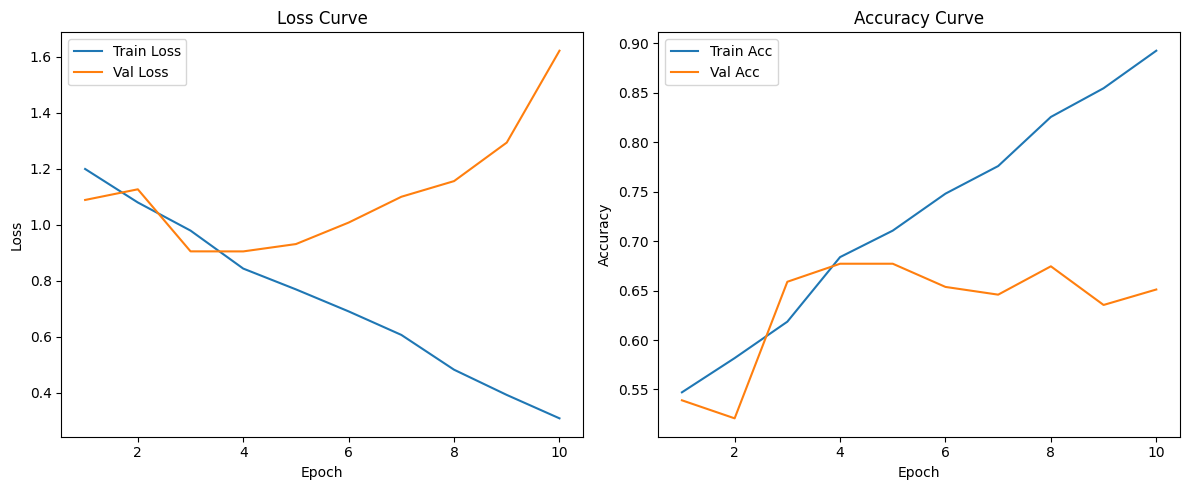

Test Accuracy: 0.6233766233766234


In [ ]:
# Define CNN model
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.ReLU(),     #ReLU is an activation function that introduces non-linearity into the model.
            nn.MaxPool2d(2),   #reduce computational load and control overfitting.,Reduces the size of the feature map and retains the most important information, making the model more efficient and robust.

            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.fc = nn.Sequential(
            nn.Linear(128 * (IMG_SIZE // 8) * (IMG_SIZE // 8), 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)  # flatten
        x = self.fc(x)
        return x



model = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

# Train the model
train_losses, val_losses, train_accs, val_accs = train_model(model, train_loader, val_loader, EPOCHS)

# Plot metrics
epochs_range = range(1, EPOCHS+1)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label="Train Loss")
plt.plot(epochs_range, val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss Curve")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accs, label="Train Acc")
plt.plot(epochs_range, val_accs, label="Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy Curve")

plt.tight_layout()
plt.show()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

evaluate(model, test_loader)


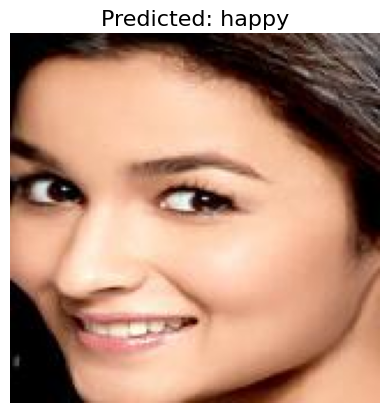

'happy'

In [ ]:
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

def predict_and_plot(image_path, model, class_names, device='cuda' if torch.cuda.is_available() else 'cpu'):
    # Set model to eval mode
    model.eval()

    # Define same transform as val/test
    transform = transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
    ])

    # Load and preprocess image
    image = Image.open(image_path).convert('RGB')
    input_tensor = transform(image).unsqueeze(0).to(device)

    # Inference
    with torch.no_grad():
        output = model(input_tensor)
        predicted_class = torch.argmax(output, dim=1).item()
        predicted_label = class_names[predicted_class]

    # Plot image with predicted label
    plt.imshow(image)
    plt.title(f'Predicted: {predicted_label}', fontsize=16)
    plt.axis('off')
    plt.show()

    return predicted_label


predict_and_plot ('/content/dataset/Faces/Faces/Alia Bhatt_62.jpg', model, class_names)

## Pretrained Model - Transfer Learning

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:08<00:00, 66.6MB/s]


Epoch [1/10], Train Loss: 1.4838, Train Acc: 0.5778, Val Loss: 0.9308, Val Acc: 0.6094
Epoch [2/10], Train Loss: 0.9198, Train Acc: 0.6609, Val Loss: 1.1056, Val Acc: 0.6094
Epoch [3/10], Train Loss: 0.8421, Train Acc: 0.6988, Val Loss: 1.0623, Val Acc: 0.5990
Epoch [4/10], Train Loss: 0.7427, Train Acc: 0.7462, Val Loss: 1.0172, Val Acc: 0.6016
Epoch [5/10], Train Loss: 0.6632, Train Acc: 0.7736, Val Loss: 1.1796, Val Acc: 0.6146
Epoch [6/10], Train Loss: 0.5610, Train Acc: 0.8042, Val Loss: 1.2221, Val Acc: 0.5859
Epoch [7/10], Train Loss: 0.5501, Train Acc: 0.8148, Val Loss: 1.2729, Val Acc: 0.5938
Epoch [8/10], Train Loss: 0.5211, Train Acc: 0.8243, Val Loss: 1.4166, Val Acc: 0.5833
Epoch [9/10], Train Loss: 0.4783, Train Acc: 0.8394, Val Loss: 1.3919, Val Acc: 0.6094
Epoch [10/10], Train Loss: 0.4167, Train Acc: 0.8617, Val Loss: 1.8456, Val Acc: 0.5859


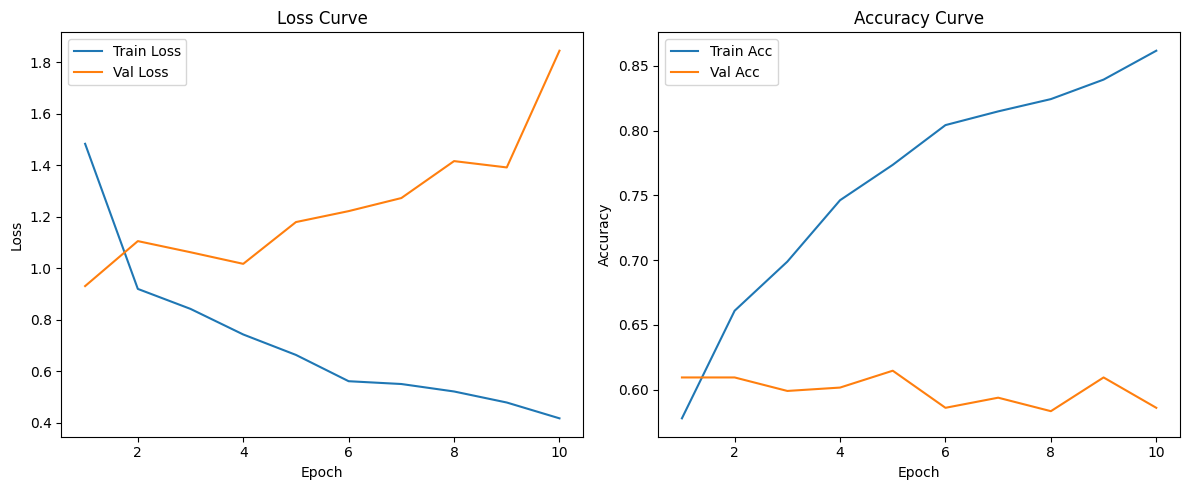

Test Accuracy: 0.6181818181818182


In [ ]:
import torch
import torch.nn as nn
from torchvision.models import vgg16, VGG16_Weights

class PretrainedVGG16(nn.Module):
    def __init__(self, num_classes=2):
        super(PretrainedVGG16, self).__init__()

        # Load pretrained model using new 'weights' argument
        base_model = vgg16(weights=VGG16_Weights.DEFAULT)

        # Freeze feature extractor
        for param in base_model.features.parameters():
            param.requires_grad = False

        self.features = base_model.features

        # Replace classifier for binary classification
        self.classifier = nn.Sequential(
            nn.Linear(512 * 4 * 4, 4096),
            nn.ReLU(True),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(0.5),
            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

model = PretrainedVGG16(num_classes=31).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

# Train the model
train_losses, val_losses, train_accs, val_accs = train_model(model, train_loader, val_loader, EPOCHS)

# Plot metrics
epochs_range = range(1, EPOCHS+1)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label="Train Loss")
plt.plot(epochs_range, val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss Curve")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accs, label="Train Acc")
plt.plot(epochs_range, val_accs, label="Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy Curve")

plt.tight_layout()
plt.show()



evaluate(model, test_loader)


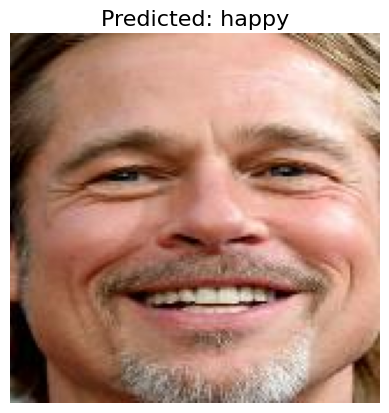

'happy'

In [ ]:
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

def predict_and_plot(image_path, model, class_names, device='cuda' if torch.cuda.is_available() else 'cpu'):
    # Set model to eval mode
    model.eval()

    # Define same transform as val/test
    transform = transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
    ])

    # Load and preprocess image
    image = Image.open(image_path).convert('RGB')
    input_tensor = transform(image).unsqueeze(0).to(device)

    # Inference
    with torch.no_grad():
        output = model(input_tensor)
        predicted_class = torch.argmax(output, dim=1).item()
        predicted_label = class_names[predicted_class]

    # Plot image with predicted label
    plt.imshow(image)
    plt.title(f'Predicted: {predicted_label}', fontsize=16)
    plt.axis('off')
    plt.show()

    return predicted_label


predict_and_plot ('/content/dataset/Faces/Faces/Brad Pitt_22.jpg', model, class_names)